In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
sns.set()

In [4]:
df = pd.read_csv("loans.csv", header = 6)

In [9]:
df.count()

LOAN_ID                            1682790
LOAN_NAME                          1634235
ORIGINAL_LANGUAGE                  1638581
DESCRIPTION                        1638546
DESCRIPTION_TRANSLATED             1229155
FUNDED_AMOUNT                      1682790
LOAN_AMOUNT                        1682790
STATUS                             1682790
IMAGE_ID                           1638581
VIDEO_ID                               847
ACTIVITY_NAME                      1682790
SECTOR_NAME                        1682790
LOAN_USE                           1638558
COUNTRY_CODE                       1682761
COUNTRY_NAME                       1682790
TOWN_NAME                          1519275
CURRENCY_POLICY                    1682790
CURRENCY_EXCHANGE_COVERAGE_RATE    1345464
CURRENCY                           1682790
PARTNER_ID                         1664465
POSTED_TIME                        1682790
PLANNED_EXPIRATION_TIME            1310956
DISBURSE_TIME                      1679601
RAISED_TIME

In [5]:
#Create an extra column, GENDER_GROUPS, that separates into females/males/multiple
df['GENDER_GROUPS'] = df['BORROWER_GENDERS']
df['GENDER_GROUPS'][(df['GENDER_GROUPS']=='male') | (df['GENDER_GROUPS']=='female')]
df['GENDER_GROUPS'] = df['GENDER_GROUPS'].where((df['GENDER_GROUPS']=='male') | (df['GENDER_GROUPS']=='female'),'group')

In [33]:
#create the funded an unfunded dataframes
expired = df[df['STATUS']=='expired']
funded = df[df['STATUS']=='funded']

In [34]:
#create the unfunded_rate
unfunded_rate = expired['LOAN_ID'].count()/(funded['LOAN_ID'].count()+expired['LOAN_ID'].count())

In [13]:
def get_funded_df(df,column_to_explore):
    '''
    Takes the Kiva loan df and creates a new df that pivots on the desired column to explore and takes the count between 
    expired and funded loans. Then creates,removes,renames columns so that the df only contains the category values as 
    rows names and funded/unfunded/total as columns headers. 
    '''
    pivot = df.pivot_table(values = 'LOAN_ID', index = column_to_explore, columns = 'STATUS', aggfunc = 'count')
    pivot['FUNDED'] = pivot['funded']
    pivot['UNFUNDED'] = pivot['expired']
    pivot['TOTAL'] = pivot['expired']+ pivot['funded']
    pivot = pivot.drop(['fundRaising','refunded','expired','funded'],axis=1)
    
    return pivot

In [14]:
def beta_distributions(df,x):
    
    '''
    Takes the funded DataFrame and returns a dict that contains the beta probability density function for 
    total amount of funded and unfunded loans based on each variable
    '''

    beta_functions = {}

    for row in df.reset_index().iloc[:,0]:
        alpha = df.loc[row,'FUNDED']
        beta = df.loc[row,'UNFUNDED']
        beta_functions[row] = stats.beta(alpha,beta).pdf(x)
        
    return beta_functions

In [15]:
def beta_rvs(df,samples):
    
    '''
    Takes the funded DataFrame and returns a dict that contains random samples based on the beta distribution for 
    total amount of funded and unfunded loans based on each variable
    '''

    beta_rvs = {}

    for row in df.reset_index().iloc[:,0]:
        alpha = df.loc[row,'FUNDED']
        beta = df.loc[row,'UNFUNDED']
        beta_rvs[row] = stats.beta(alpha,beta).rvs(samples)
        
    return beta_rvs

In [16]:
def graph_beta(function_dict,x):

    for label,function in function_dict.items(): 
        plot_with_fill(x,function,label)
        ax.annotate(label,rotation=0,xy=((function.argmax()/10000),function.max()),
                    xytext=((function.argmax()/10000)+0.003,(function.max())+50),
                    arrowprops=dict(arrowstyle="simple",fc="0.5", ec="none",connectionstyle="arc3,rad=0.3"))
        ax.annotate('Average Funded Rate',xy=(0.954122810959807,1600),xytext=(0.955,1450),)
        ax.axvline(0.954122810959807, color='b', linestyle=':')
        
    return ax

In [36]:
def plot_with_fill(x, y, label):
    lines = plt.plot(x, y, label=label, lw=2)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_c())
    plt.legend(loc='best')

In [37]:
country_top = df.groupby('COUNTRY_NAME')['LOAN_ID'].count().sort_values(ascending=False).head(25)

Text(0.5, 0, 'Number of Loans')

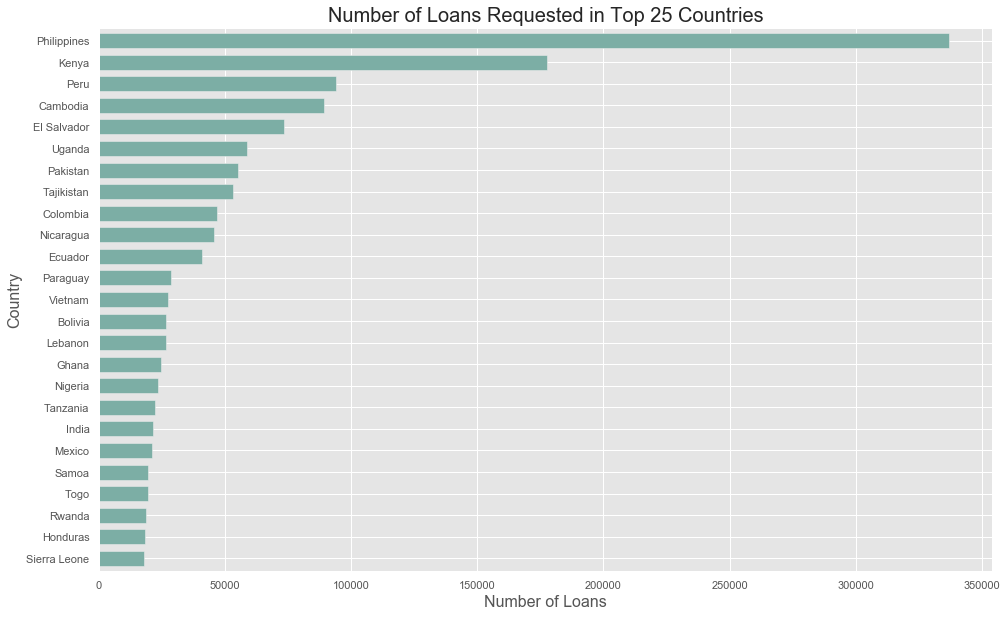

In [38]:
ax = country_top.plot(kind='barh', figsize=(16,10), color='#7caea5', zorder=2, width=0.7)

ax.invert_yaxis()
plt.title('Number of Loans Requested in Top 25 Countries',fontsize = 20)
plt.ylabel('Country',fontsize = 16)
plt.xlabel('Number of Loans',fontsize = 16)

In [39]:
country_df = get_funded_df(df,'COUNTRY_NAME')
country_df = country_df.fillna(0)
country_df['TOTAL'] = country_df['FUNDED'] + country_df['UNFUNDED']
country_df = country_df.sort_values('TOTAL',ascending=False).head(10)

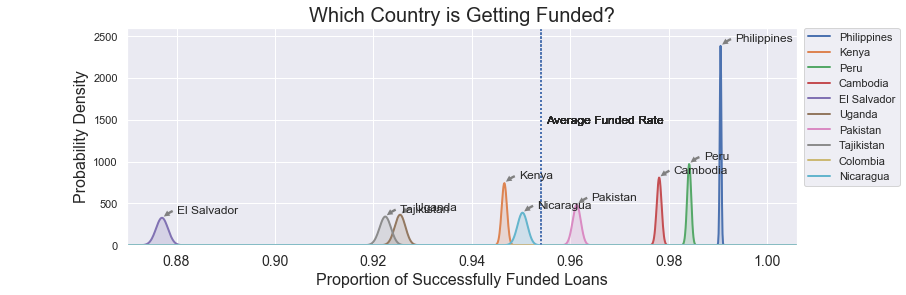

In [106]:
fig,ax = plt.subplots(figsize=(12,4))
x = np.arange(0,1.1,.0001)

country_beta = beta_distributions(country_df,x)
graph_beta(country_beta,x)

plt.xlim(0.87,1.006)
plt.ylim(0,2600)
plt.ylabel('Probability Density',fontsize=16)
plt.xlabel('Proportion of Successfully Funded Loans',fontsize=16)
plt.title('Which Country is Getting Funded?',fontsize=20)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [110]:
country_rvs = beta_rvs(country_df,10000)
prob1 = (country_rvs['Uganda'] > country_rvs['Tajikistan']).mean() * 100
prob = (country_rvs['Philippines'] > country_rvs['Peru']).mean() * 100
print('There is a {:.2f}% probability that Uganda is getting a higher proportion of successfully funded loans than Tajikistan\n'.format(prob))

There is a 100.00% probability that Uganda is getting a higher proportion of successfully funded loans than Tajikistan



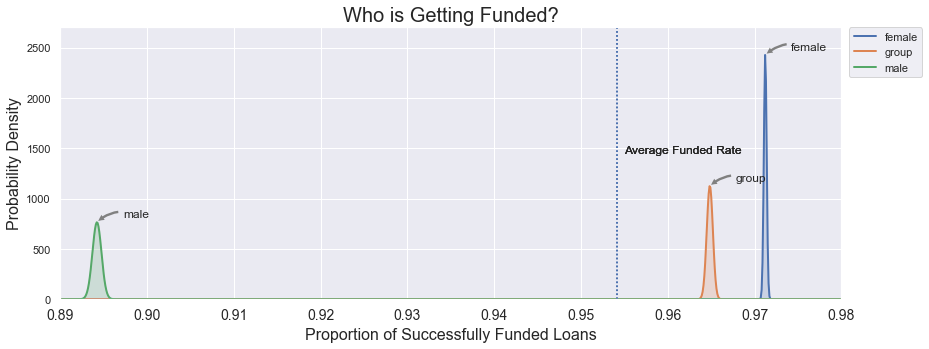

In [20]:
fig,ax = plt.subplots(figsize=(14,5))
x = np.arange(0,1.1,.0001)

gender_df = get_funded_df(df,'GENDER_GROUPS')
gender_beta = beta_distributions(gender_df,x)
graph_beta(gender_beta,x)

plt.xlim(0.89,0.98)
plt.ylim(0,2700)
plt.ylabel('Probability Density',fontsize=16)
plt.xlabel('Proportion of Successfully Funded Loans',fontsize=16)
plt.title('Who is Getting Funded?',fontsize=20)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [118]:
prob1 = (gender_rvs['female'] > gender_rvs['male'] + .076).mean() * 100
prob2 = (gender_rvs['female'] > gender_rvs['male'] + .077).mean() * 100
prob3 = (gender_rvs['female'] > gender_rvs['male'] + .078).mean() * 100
print('There is a {:.2f}% probability that a single female asking for a loan has a 7.5% better chance than a single male to have the loan successfully funded\n'.format(prob1))
print('There is a {:.2f}% probability that a single female asking for a loan has a 7.75% better chance than a single male to have the loan succesfully funded\n'.format(prob2))
print('There is a {:.2f}% probability that a single female asking for a loan has a 8.0% better chance than a single male to have the loan successfully funded\n'.format(prob3))

There is a 96.58% probability that a single female asking for a loan has a 7.5% better chance than a single male to have the loan successfully funded

There is a 49.86% probability that a single female asking for a loan has a 7.75% better chance than a single male to have the loan succesfully funded

There is a 3.28% probability that a single female asking for a loan has a 8.0% better chance than a single male to have the loan successfully funded



In [91]:
gender_rvs =  beta_rvs(gender_df,10000)
(gender_rvs['female'] > gender_rvs['male'] + .0775).mean()

0.175

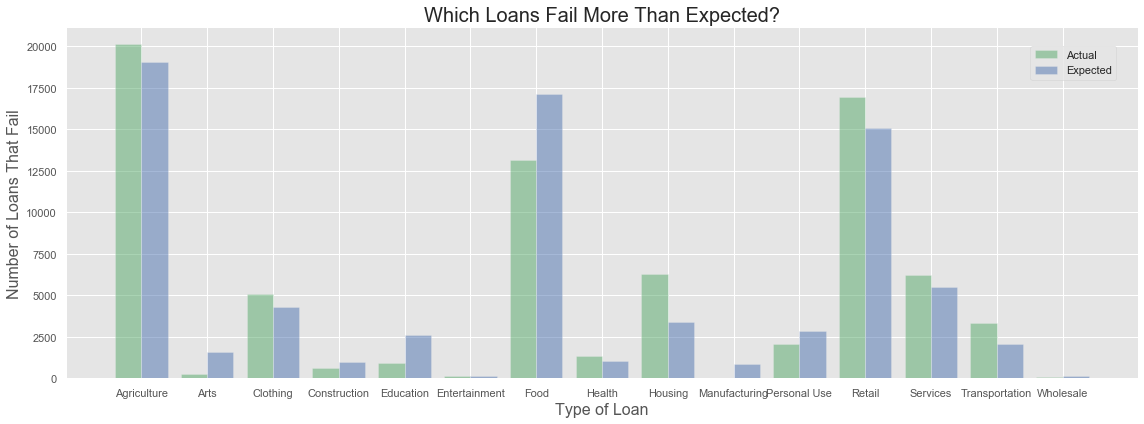

In [35]:
fig,ax = plt.subplots(figsize=(16,6))

unfunded = ax.bar(sector_df.index, sector_df['UNFUNDED'],color='g',width = -0.4,align ='edge',alpha=.5,label='Actual')
expected = ax.bar(sector_df.index, (sector_df['TOTAL'] * unfunded_rate),color='b',width = 0.4,align ='edge',alpha=.5,label='Expected')

plt.xlabel('Type of Loan',fontsize=16)
plt.ylabel('Number of Loans That Fail',fontsize=16)
plt.title('Which Loans Fail More Than Expected?',fontsize=20)
plt.legend(bbox_to_anchor=(.9, .85), loc=3, borderaxespad=0.)

fig.tight_layout()

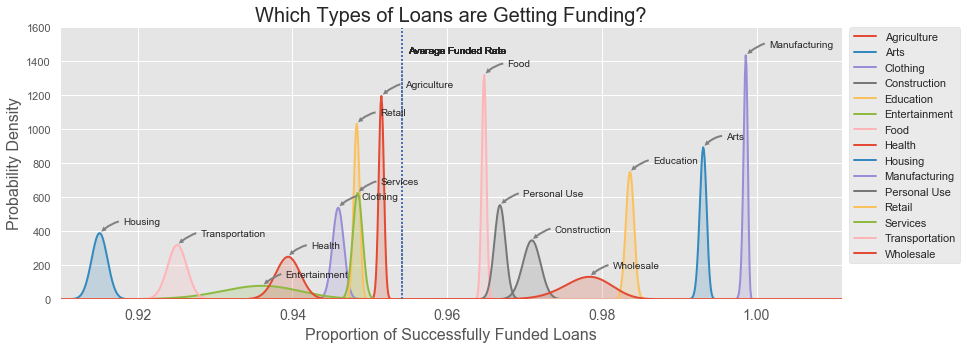

In [31]:
fig,ax = plt.subplots(figsize=(14,5))
x = np.arange(0,1.1,.0001)

sector_df = get_funded_df(df,'SECTOR_NAME')
sector_beta = beta_distributions(sector_df,x)
graph_beta(sector_beta,x)

plt.xlim(0.91,1.011)
plt.ylim(0,1600)
plt.ylabel('Probability Density',fontsize=16)
plt.xlabel('Proportion of Successfully Funded Loans',fontsize=16)
plt.title('Which Types of Loans are Getting Funding?',fontsize=20)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [105]:
sector_rvs = beta_rvs(sector_df,10000)
(sector_rvs['Health'] > sector_rvs['Entertainment']).mean()

0.7578